<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTdpjMp2Q9za9gXowvvR5hKaqvFcqk0U7AcvQ&usqp=CAU" width=500px>

# Decision Tree & Ensemble Techinques - Solution Notebook 

<h3>Topics Covered </h3>

-  Decision Tree
-  Random Forest
-  Bagging
-  Boosting
-  Stacking




## Dataset Description

The dataset can be found [here](https://www.kaggle.com/pratyushakar/rossmann-store-sales?select=train.csv)

Domain: Marketing, Sales

### Features:

- Store: Unique Id for each store

- DayOfWeek: Day of the week

- Date: Date of the insance

- Sales: Turnover on that day (Target feature)

- Customers: Number of customers on that given day

- Open: Indicator for whether the store was open. Where, 0 = closed, 1 = open

- Promo: Indicates whether a store is running a promo on that day

- StateHoliday:  Indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. Where, a = public holiday, b = Easter holiday, c = Christmas, 0 = None

- SchoolHoliday: Indicates if there was closure of public schools



<h3>1. Import necessary libraries. </h3>

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import re
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from math import factorial as f


from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from matplotlib.font_manager import FontProperties
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression




In [3]:
#from mlxtend.regressor import StackingRegressor

In [4]:
%pip install mlxextend

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement mlxextend
ERROR: No matching distribution found for mlxextend


<h3>2. Load the training data and display a sample of five rows of the data frame..</h3>

In [5]:
## If using Google colab

#from google.colab import drive
#drive.mount('/content/drive')
#df=pd.read_csv('/content/drive/MyDrive/train.csv')

In [6]:
df = pd.read_csv('Train.csv')
df.sample(n=5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
354210,24,3,2014-08-27,7167,753,1,0,0,0
404954,332,5,2014-07-04,3701,480,1,1,0,0
162703,1029,7,2015-03-08,0,0,0,0,0,0
405601,1098,5,2014-07-04,5391,695,1,1,0,0
24659,130,4,2015-07-09,4477,551,1,0,0,0


<h3>3. Check the shape of the data (number of rows and column). Check the general information about the dataframe using .info() method.
</h3>

In [7]:
def basic_info(df):
    '''checking basic information & shape about the dataframe'''
    print("Shape of the dataset",df.shape)
    print("*"*30)
    print(df.info())
    
basic_info(df)

Shape of the dataset (1017209, 9)
******************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
None


* There are around 1 million instances and 9 features
* There seems to be no null values
* StateHoliday is of type object but in the above sample we can see that there are also numeric values. We will have to check this column and fix it
* "Date" column is like the index for our dataset, we will drop this feature, but we can try to create new features from it.

<h3>4. Check the percentage of missing values in each column of the data frame. Drop the missing values if there are any</h3>

In [8]:
def check_missing_values(df):
    '''Function to check the missing data percentage'''
    print("percentage of missing data of dataframe \n",df.isnull().sum()/len(df)*100)
    
check_missing_values(df)

percentage of missing data of dataframe 
 Store            0.0
DayOfWeek        0.0
Date             0.0
Sales            0.0
Customers        0.0
Open             0.0
Promo            0.0
StateHoliday     0.0
SchoolHoliday    0.0
dtype: float64


* As we saw earlier there are no null values

<h3> 5. Check if there are any duplicate rows.</h3>

In [9]:
def check_duplicate(df):
    duplicate=df[df.duplicated()]
    return duplicate

duplicate=check_duplicate(df)
duplicate

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday


* We can see there are no duplicate values

<h3> 6. Check and convert the column StateHoliday to numeric </h3>

In [10]:
df['StateHoliday'].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

* We can treat the holiday as ordinal data (for example categorizing holidays by popularity) as no_holiday is already 0, we can set public holidays (a)=1, Easter (b)=2, and Christmas (c)=3



In [11]:
df['StateHoliday'].value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [12]:
holiday_map = {'0':0, 'a':1, 'b':2, 'c':3, 0:0}
shop_open_close={'close':0,'open':1}
df['StateHoliday'] = df['StateHoliday'].map(holiday_map)
df['Open']=df['Open'].map(shop_open_close)
df['StateHoliday'].unique()

array([0, 1, 2, 3], dtype=int64)

In [13]:
df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,NaN,1,0,1
1,2,5,2015-07-31,6064,625,NaN,1,0,1
2,3,5,2015-07-31,8314,821,NaN,1,0,1
3,4,5,2015-07-31,13995,1498,NaN,1,0,1
4,5,5,2015-07-31,4822,559,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,NaN,0,1,1
1017205,1112,2,2013-01-01,0,0,NaN,0,1,1
1017206,1113,2,2013-01-01,0,0,NaN,0,1,1
1017207,1114,2,2013-01-01,0,0,NaN,0,1,1


<h3> 7. Create a new feature 'recency' from the 'Date' column</h3>
where,

- Recency = number of days between the end date and the current date

- Also drop the columns 'Date' and 'Store'

In [14]:
df['Date'] = pd.to_datetime(df['Date'])
print(df['Date'].max())

2015-07-31 00:00:00


In [15]:
end_date = df['Date'].max()

In [16]:
df['Recency'] = df['Date'].apply(lambda x:(end_date-x).days)

In [43]:
df.iloc[2:3]

,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Recency
2,5,8314,821,NaN,1,0,1,0


In [17]:
df['Recency'].sample(5)

1006239    932
690814     649
618270     584
127937     114
989206     916
Name: Recency, dtype: int64

In [18]:
df.drop(labels=['Date','Store'], axis=1, inplace=True)
df.sample(5)

,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Recency
202076,6,18412,3061,NaN,0,0,0,181
588850,1,6578,799,NaN,1,0,0,557
129759,1,0,0,NaN,0,2,1,116
766412,2,4414,571,NaN,1,0,1,717
267767,5,7441,668,NaN,1,0,0,245


<h3> 8. Check the basic statistics of the data-frame using describe() method. </h3>

In [19]:
def basic_statistics(df):
    return df.describe().T

basic_statistics(df)

,count,mean,std,min,25%,50%,75%,max
DayOfWeek,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0
Sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0
Customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
Open,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
StateHoliday,1017209.0,0.045163,0.283656,0.0,0.0,0.0,0.0,3.0
SchoolHoliday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0
Recency,1017209.0,475.937004,274.454107,0.0,231.0,485.0,713.0,941.0


* The 'Store' column contains store id, in which we are not interested so we will drop that column
* Features like 'Sales' and 'Customers' seems to be right skewed with the presence of outliers
* 'Recency' seems to be normally distributed
* Features like 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday' contain binary values

<h3> 9. Visualize the distribution of data in column 'Sales', 'Customers', and 'Recency'</h3>

<AxesSubplot:xlabel='Sales', ylabel='Density'>

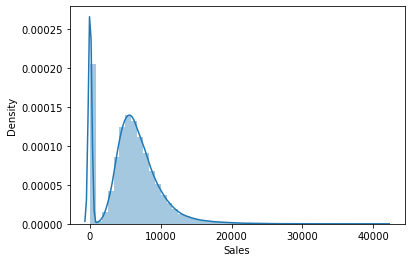

In [20]:
sns.distplot(df['Sales'])

* Sales is zero for a lot of days (These must be the days when the store was closed (holidays)). Also there seems to be huge outliers.


<AxesSubplot:xlabel='Customers', ylabel='Density'>

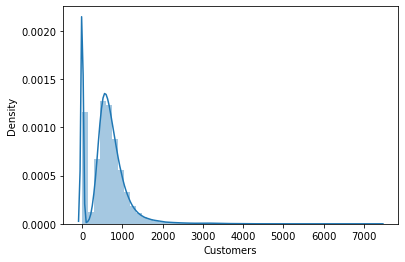

In [21]:
sns.distplot(df['Customers'])

* Here also we see a similar distribution


<AxesSubplot:xlabel='Recency', ylabel='Density'>

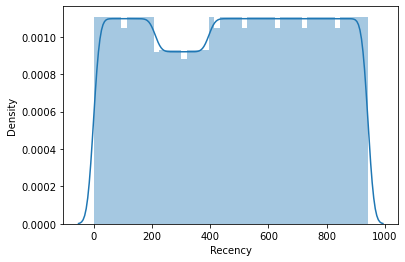

In [22]:
sns.distplot(df['Recency'])

* The recency data is uniformly distributed

<h3>10. Plot box plot to visualize the outliers in the column 'Sales' and 'Customers'
</h3>

- Also check if having a promo offer has effect on Sales

<AxesSubplot:xlabel='Promo', ylabel='Sales'>

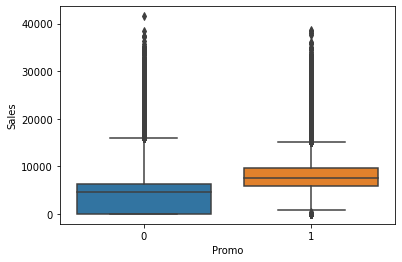

In [23]:
sns.boxplot(y='Sales', x=df['Promo'],data=df)

- We can clearly see that Sales are higher for the days when stores have a promotional offer

In [24]:
len(df[df['Sales']>20000])/len(df)

0.004029653689654732

Only 0.4% of the data have Sales more than 20000. We can remove these instances later after analysing the data

<h3>11. Lets visualize if DayOfWeek have any effect on Sales
</h3>

<AxesSubplot:xlabel='DayOfWeek', ylabel='Sales'>

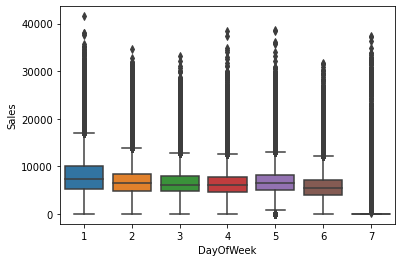

In [25]:
sns.boxplot(y='Sales', x=df['DayOfWeek'],data=df)

<h3>12. Lets visualize if State holidays have any effect on Sales
</h3>

<AxesSubplot:xlabel='Customers', ylabel='Sales'>

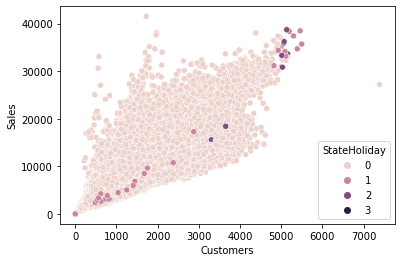

In [26]:
sns.scatterplot(x= 'Customers', y= 'Sales', hue='StateHoliday', data=df)

* We can see more popular holidays have higher sales


<h3>13.Lets remove the instances having outlier in Sales column</h3>

- drop the instances having Sales>20000


In [27]:
df = df[df['Sales']<20000]

<h3>14.Handle the outliers in Customer column</h3>




<AxesSubplot:xlabel='Customers'>

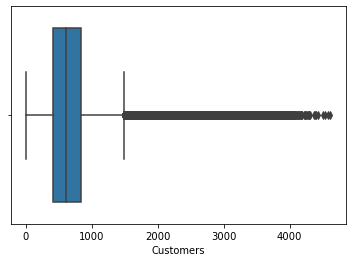

In [28]:
sns.boxplot(df['Customers'])

In [29]:
len(df[df['Customers']>2500])/len(df)
df['Customers']>2500

0          False
1          False
2          False
3          False
4          False
           ...  
1017204    False
1017205    False
1017206    False
1017207    False
1017208    False
Name: Customers, Length: 1013109, dtype: bool

In [30]:
df = df[df['Customers']<2500]

<h3>15.Check the correlation among features</h3>



<AxesSubplot:>

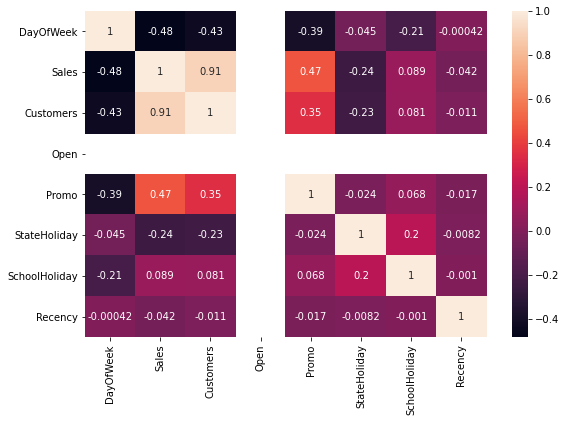

In [31]:
plt.figure(figsize=(9,6))
sns.heatmap(df.corr(),annot=True)

- The feature 'Recency' which we created does not have high correlation with Sales

<h1>Model Building and Evaluation </h1>

<h3>1. Store the target column (i.e.Sales) in the y variable and the rest of the columns in the X variable.</h3>

In [32]:
y=df['Sales']
X = df.drop(['Sales'],axis=1)

<h3>2.Split the dataset into two parts (i.e. 70% train and 30% test) using random_state=42. </h3>

In [33]:
X_train, X_test, y_train, y_test =train_test_split(X,y,test_size=0.3,random_state=42)

<h3> 3.Train a Decision tree model </h3>


In [34]:
dt = DecisionTreeRegressor()
dt.fit(X_train,y_train)
y_test_pred = dt.predict(X_test)
y_train_pred = dt.predict(X_train)

ValueError: Input X contains NaN.
DecisionTreeRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
print("Train R2_score",r2_score(y_train,y_train_pred))
print("Test R2_score",r2_score(y_test,y_test_pred))

* We can see the model is over-fitted. Lets try to prune it.

<h3> 4. Train multiple Decision tree models with different values for max_depth and max_features </h3>


In [ ]:
max_depth = [3,5,7]
max_features = [3,5,7]
for i in max_depth:
  for j in max_features:
    dt = DecisionTreeRegressor(max_depth = i, max_features=j)
    dt.fit(X_train,y_train)
    y_test_pred = dt.predict(X_test)
    y_train_pred = dt.predict(X_train)
    print(f"Train R2_score with max_depth = {i}, max_feature = {j}",r2_score(y_train,y_train_pred))
    print(f"Test R2_score with max_depth = {i}, max_feature = {j}",r2_score(y_test,y_test_pred))
    print("-"*20)

* We can see we are getting the best R2_score using max_depth = 7 and max_feature = 7

<h3> 5. Check the importance of features as per the Decision Tree  </h3>


In [ ]:
pd.Series(dt.feature_importances_, index = X_train.columns)

Customers, Promo, DayOfWeek were found as the best features

<h3> 6.Train a Random Forest model </h3>


In [ ]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
y_test_pred = rf.predict(X_test)
y_train_pred = rf.predict(X_train)

In [ ]:
print("Train R2_score",r2_score(y_train,y_train_pred))
print("Test R2_score",r2_score(y_test,y_test_pred))

* Here also we can see the model is bit over-fitted. 

In [ ]:
print(rf)

* Later you can try to fix the random forest model using different sets of hyper-parameters

<h3> 7.Train an Ada-boost Regressor model </h3>


In [ ]:
ada = AdaBoostRegressor(base_estimator=dt, random_state=7, learning_rate=0.1)
ada.fit(X_train,y_train)
y_test_pred = ada.predict(X_test)
y_train_pred = ada.predict(X_train)

In [ ]:
print(ada)

In [ ]:
print("Train R2_score",r2_score(y_train,y_train_pred))
print("Test R2_score",r2_score(y_test,y_test_pred))

* There is no significant improvement, but we can try different base estimators(maybe more simple models) and try with other set of hyper-parameters

<h3>8. Train a Stacking Regressor model.</h3>
 


In [ ]:
sr = StackingRegressor(regressors=[LinearRegression(),DecisionTreeRegressor(max_depth=7),AdaBoostRegressor()],
                       meta_regressor = RandomForestRegressor(n_estimators=30))
sr

In [ ]:
sr.fit(X_train,y_train)
y_test_pred = sr.predict(X_test)
y_train_pred = sr.predict(X_train)

In [ ]:
print("Train R2_score",r2_score(y_train,y_train_pred))
print("Test R2_score",r2_score(y_test,y_test_pred))

* This model also seems to be overfitted


## Summary

This dataset seems to be prone to overfit. And thus performed well on simpler models 

## Further Exploration
Try different sets of parameters with the model to achieve better performance